In [1]:
#!pip install pandas_datareader
#pip install statsmodels 
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline

In [2]:
start = dt.datetime(2002,1,1)
end = dt.datetime(2018,1,1)

In [3]:
tata = data.DataReader("TATACONSUM.NS",'yahoo',start,end)

In [4]:
tata.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-01,17.500000,16.799999,17.350000,16.905001,722730.0,11.417471
2002-01-02,17.184999,16.799999,17.000000,16.850000,290270.0,11.380325
2002-01-03,17.200001,16.870001,16.955000,17.059999,360580.0,11.522154
2002-01-04,17.299999,16.809999,17.270000,16.955000,682690.0,11.451240
2002-01-07,17.750000,17.049999,17.200001,17.400000,840670.0,11.751787


In [5]:
tata['Daily Returns'] = 100*tata['Adj Close'].pct_change()

In [6]:
tata['Daily Returns'].fillna(0,inplace=True)

In [7]:
tata['Daily Returns'].describe()

count    3989.000000
mean        0.104589
std         2.120263
min       -12.665398
25%        -1.090638
50%         0.000000
75%         1.199543
max        14.606668
Name: Daily Returns, dtype: float64

In [8]:
tata['Daily Returns'].skew()

0.26398440539583773

In [9]:
tata['Daily Returns'].kurt()

3.861631096562856

### Augmented Dickey-Fuller test
This is a statistical test that is dedicatedly built to test whether univariate time series data is stationary or not. This test is based on a hypothesis and can tell us the degree of probability to which it can be accepted. It is often classified under one of the unit root tests, It determines how strongly, a univariate time series data follows a trend. Let’s define the null and alternate hypotheses,

Ho (Null Hypothesis): The time series data is non-stationary
H1 (alternate Hypothesis): The time series data is stationary
Assume alpha = 0.05, meaning (95% confidence). The test results are interpreted with a p-value if p > 0.05 Accept the null hypothesis, else if p <= 0.05 reject the null hypothesis

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
values1 = tata['Adj Close'].values
values2 = tata['Daily Returns'].values

In [12]:
res1 = adfuller(values1)
res2 = adfuller(values2)

In [13]:
print('Augmneted Dickey_fuller Statistic for Closing Price: %f' % res1[0])
print('p-value: %f' % res1[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res1[4].items():
    print('\t%s: %.3f' % (k, v))


print("---------------------------------------------------------------------\n")
print('Augmneted Dickey_fuller Statistic for Daily Returns: %f' % res2[0])
print('p-value: %f' % res2[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res2[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic for Closing Price: 2.249136
p-value: 0.998921
critical values at different levels:
	1%: -3.432
	5%: -2.862
	10%: -2.567
---------------------------------------------------------------------

Augmneted Dickey_fuller Statistic for Daily Returns: -60.262931
p-value: 0.000000
critical values at different levels:
	1%: -3.432
	5%: -2.862
	10%: -2.567


From the above we can conclude that Closing price is not stationary but the daily returns are stationary in nature

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

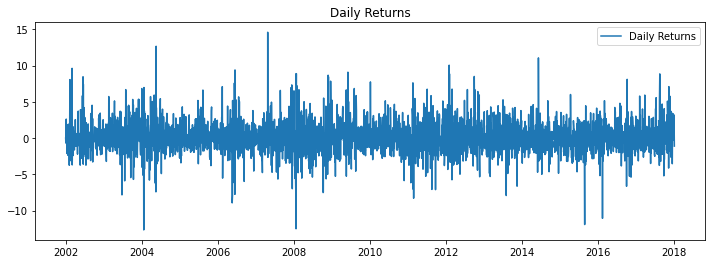

In [16]:
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(tata['Daily Returns'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns')
plt.show()

In [17]:
daily_volatility = tata['Daily Returns'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = np.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = np.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  2.12%
Monthly volatility:  9.72%
Annual volatility:  33.66%


In [18]:
tata['Daily Returns Squared'] = tata['Daily Returns'].apply(lambda x : x**2)

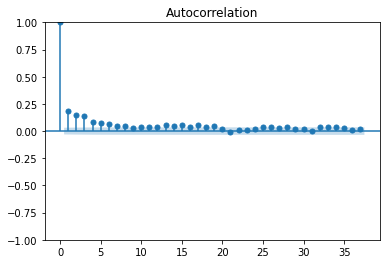

In [19]:
plot_acf(tata['Daily Returns Squared'])
plt.show()

In [26]:
from arch import arch_model
garch_model = arch_model(tata['Daily Returns'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5,reindex = True)
print(gm_forecast.variance[-1:])

mu          0.106429
omega       0.382182
alpha[1]    0.107727
beta[1]     0.808668
Name: params, dtype: float64


                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2018-01-01  3.578218  3.661243  3.737326  3.807048  3.870941


In [29]:
from arch import arch_model
egarch_model = arch_model(tata['Daily Returns'], p = 1, q = 1,
                      mean = 'constant', vol = 'EGARCH', dist = 'normal')

egm_result = garch_model.fit(disp='off')
print(egm_result.params)

print('\n')

egm_forecast = gm_result.forecast(horizon = 1,reindex = True)
print(egm_forecast.variance[-1:])

mu          0.087846
omega       0.110312
alpha[1]    0.214237
beta[1]     0.930917
Name: params, dtype: float64


                 h.1
Date                
2018-01-01  3.600456


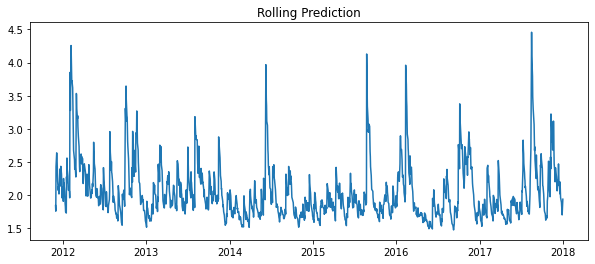

In [41]:

rolling_predictions = []
test_size = 1500

for i in range(test_size):
    train = tata['Daily Returns'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1,reindex = False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=tata['Daily Returns'].index[-1500:])

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

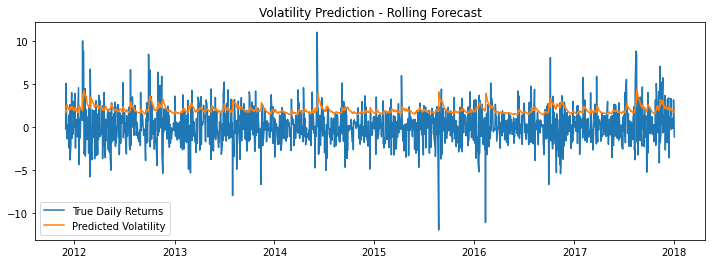

In [43]:
plt.figure(figsize=(12,4))
plt.plot(tata['Daily Returns'][-1500:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()